In [32]:
# !pip install pycaret

In [33]:
# from pycaret.classification import setup, compare_models

In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns



In [36]:
columns = ['duration',
                'protocol_type',
                'service',
                'flag',
                'src_bytes',
                'dst_bytes',
                'land',
                'wrong_fragment',
                'urgent',
                'hot',
                'num_failed_logins',
                'logged_in',
                'num_compromised',
                'root_shell',
                'su_attempted',
                'num_root',
                'num_file_creations',
                'num_shells',
                'num_access_files',
                'num_outbound_cmds',
                'is_host_login',
                'is_guest_login',
                'count',
                'srv_count',
                'serror_rate',
                'srv_serror_rate',
                'rerror_rate',
                'srv_rerror_rate',
                'same_srv_rate',
                'diff_srv_rate',
                'srv_diff_host_rate',
                'dst_host_count',
                'dst_host_srv_count',
                'dst_host_same_srv_rate',
                'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate',
                'dst_host_srv_diff_host_rate',
                'dst_host_serror_rate',
                'dst_host_srv_serror_rate',
                'dst_host_rerror_rate',
                'dst_host_srv_rerror_rate',
                'intrusion_type'
               ]

kdd = pd.read_csv('dataset/sample_data.csv', names=columns, header=None)


In [37]:
# display(kdd.isna().sum())
kdd = kdd.dropna()

In [38]:
cat_var = kdd.select_dtypes('object').columns
num_var = kdd.select_dtypes(np.number).columns

In [39]:
kdd['status'] = 'non-threat'
kdd['status'].loc[kdd.intrusion_type != 'normal.'] = 'threat'

In [40]:
kdd_target = kdd.status
kdd_type = kdd['intrusion_type']

kdd.drop(['status', 'intrusion_type'], axis = 1, inplace = True)

In [41]:
kdd1 = kdd.copy()
kdd1 = pd.get_dummies(kdd1, drop_first = True)


In [42]:
from sklearn.preprocessing import StandardScaler

kdd2 = kdd1.copy()
scaler = StandardScaler()
scaler.fit(kdd2)
kdd2 = pd.DataFrame(scaler.transform(kdd2), index = kdd2.index, columns = kdd2.columns)

In [43]:


from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(kdd2)

# print(pca.explained_variance_ratio_)


VARIANCE_TH = 0.98



In [44]:
sum(pca.explained_variance_ratio_[0:81])

0.9541979505921873

In [45]:
kdd_target = pd.get_dummies(kdd_target, drop_first = True)

In [46]:
# setup(df, target = 'threat')

In [47]:
# best = compare_models()


In [48]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, #min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1530, verbose=0,
                       warm_start=False)

models = {'RandomForest':RandomForestClassifier(random_state=42,n_estimators=100,),
           'gbc':GradientBoostingClassifier(n_estimators = 100 ,learning_rate = 0.01),
           'ExtraTrees':ExtraTreesClassifier(n_estimators = 100),
#           'knn': KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
         }

In [51]:
from sklearn.metrics import f1_score, roc_auc_score ,accuracy_score
from sklearn.model_selection import KFold


def kf_cross_val(model,X,y):
    
    scores,feature_imp,features = [],[],[]
    
    kf = KFold(n_splits=3,shuffle = True, random_state=42)
    
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        
        x_train = X.iloc[train_index]
        y_train = y.loc[train_index]
        x_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        model.fit(x_train,y_train)
        
        y_pred_proba = model.predict_proba(x_test)[:,1]   # edit
        y_pred = model.predict(x_test)
        scores.append([accuracy_score(y_test,y_pred), roc_auc_score(y_test,y_pred_proba), f1_score(y_test,y_pred)])

        
        try:
            feature_imp.append(model.feature_importances_)
            features.append(model.feature_names_)
            
        except AttributeError: # if model does not have .feature_importances_ attribute
            pass
        
    return feature_imp, scores, features


In [52]:
import warnings
warnings.filterwarnings('ignore')

results  = {}


for name,model in models.items():
    
    feature_imp,result,features = kf_cross_val(model, kdd2, kdd_target)
    results[name] = np.array(result)

for name, result in results.items():
    print("----------\n" + name)

    print('accuracy: mean-{} std-{}'.format(np.mean(result.T[0]),np.std(result.T[0])))
    print('auc: mean-{} std-{}'.format(np.mean(result.T[1]),np.std(result.T[1])))
    print('f1: mean-{} std-{}'.format(np.mean(result.T[2]),np.std(result.T[2])))


    # print(np.std(result))
    # print(feature_imp)

----------
RandomForest
accuracy: mean-0.9997793615364277 std-2.4459244350339086e-05
auc: mean-0.9999984499839707 std-1.7795856878766657e-06
f1: mean-0.9998626065350752 std-1.535186602686187e-05
----------
gbc
accuracy: mean-0.9960689907853916 std-0.0008134456249451447
auc: mean-0.9997878565966746 std-9.085987886570882e-05
f1: mean-0.9975508540187744 std-0.0005053071725117611
----------
ExtraTrees
accuracy: mean-0.9997732889692504 std-1.8771929574911112e-05
auc: mean-0.9999919954876885 std-5.4074506160916285e-06
f1: mean-0.9998588288302012 std-1.1812938021167429e-05


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( kdd2, kdd_target, test_size=0.33, random_state=42)

reg = RandomForestClassifier(n_estimators=100)
reg.fit(X_train, y_train)

RandomForestClassifier()

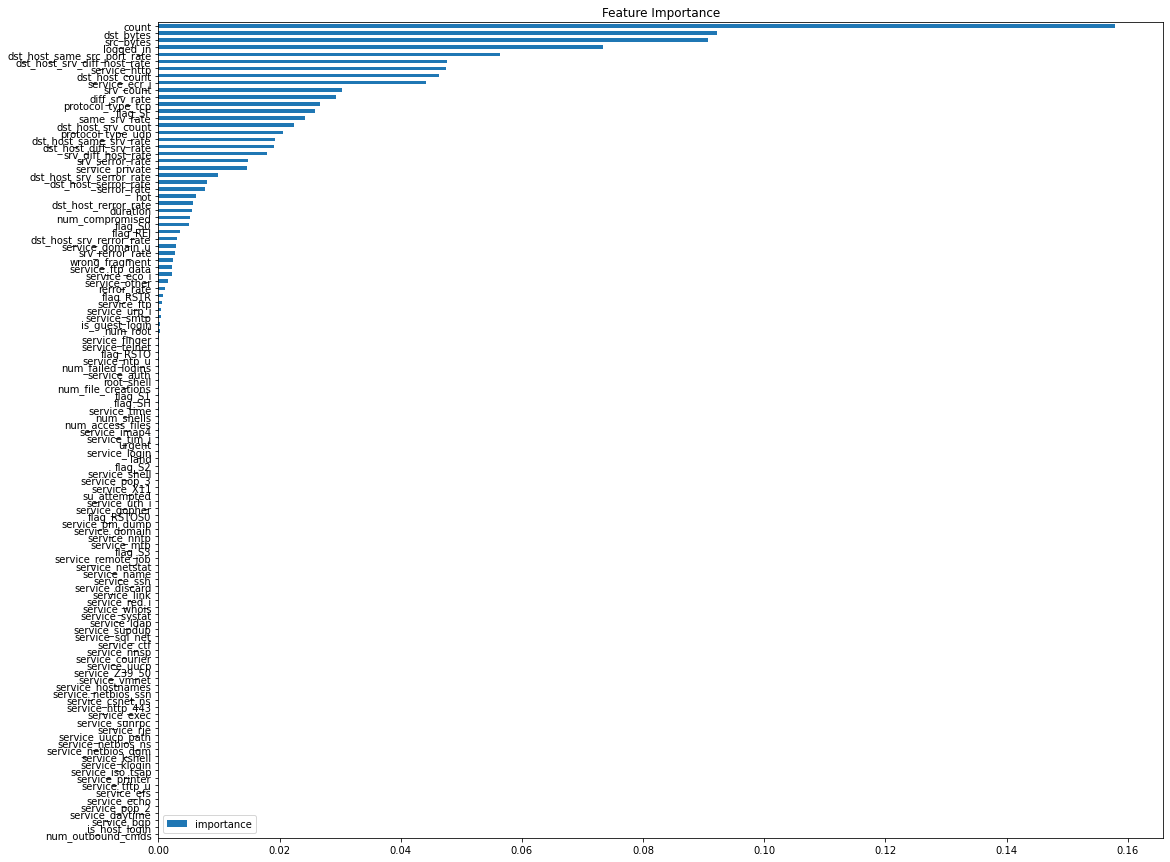

In [65]:
fg, ax = plt.subplots(figsize = (18,15))
feat_imp = pd.DataFrame(reg.feature_importances_, index = kdd2.columns, columns = ['importance'])
feat_imp.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance',ax = ax)
plt.show()

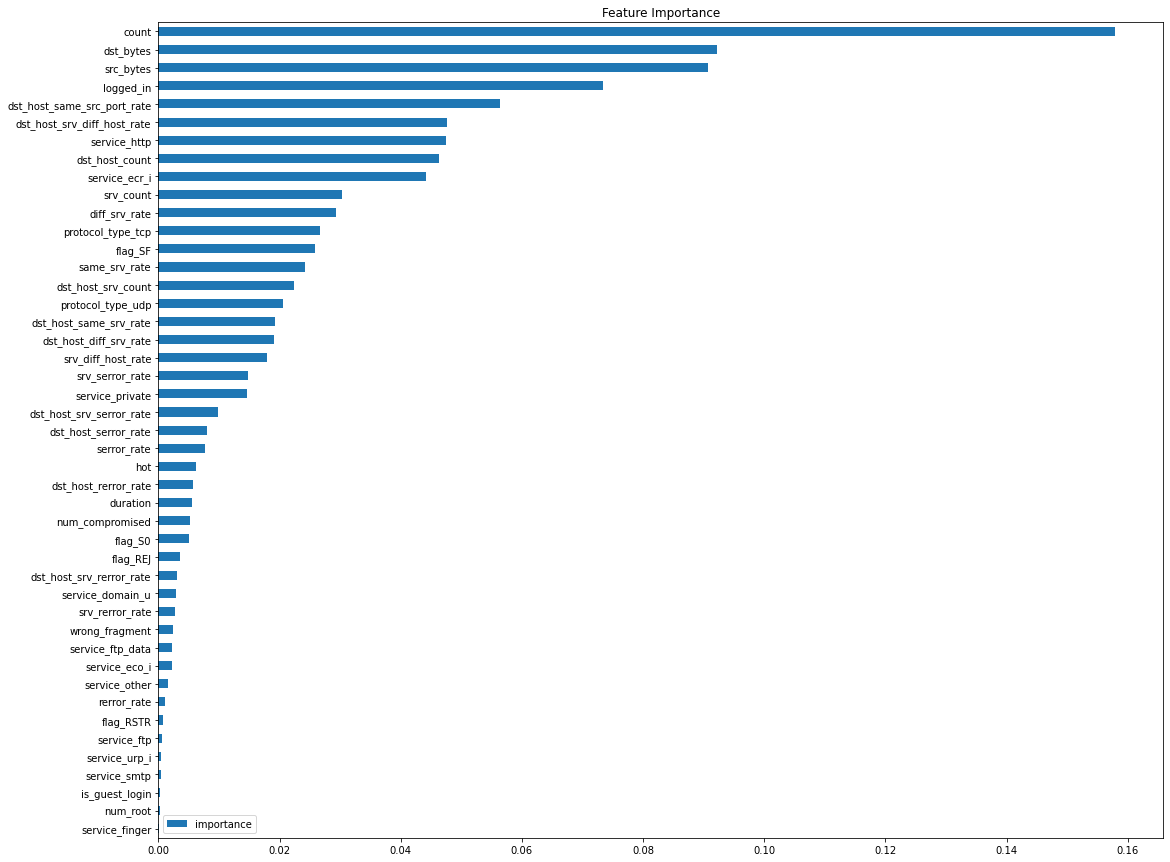

In [74]:
fg, ax = plt.subplots(figsize = (18,15))
feat_imp = pd.DataFrame(reg.feature_importances_, index = kdd2.columns, columns = ['importance'])
feat_imp.sort_values('importance').tail(45).plot(kind = 'barh', title = 'Feature Importance',ax = ax)
plt.show()

In [87]:

imp_feat = feat_imp.sort_values('importance').tail(40).index

kdd_imp = kdd2.loc[:, imp_feat]

import warnings
warnings.filterwarnings('ignore')

results  = {}


for name,model in models.items():
    
    feature_imp,result,features = kf_cross_val(model, kdd_imp, kdd_target)
    results[name] = np.array(result)

for name, result in results.items():
    print("----------\n" + name)

    print('accuracy: mean-{} std-{}'.format(np.mean(result.T[0]),np.std(result.T[0])))
    print('auc: mean-{} std-{}'.format(np.mean(result.T[1]),np.std(result.T[1])))
    print('f1: mean-{} std-{}'.format(np.mean(result.T[2]),np.std(result.T[2])))


----------
RandomForest
accuracy: mean-0.9997975793977588 std-2.235862675545356e-05
auc: mean-0.9999984065092349 std-1.7766835246583994e-06
f1: mean-0.9998739495990089 std-1.4046448579256086e-05
----------
gbc
accuracy: mean-0.9963159448744957 std-0.00048109831022197924
auc: mean-0.999784433448948 std-8.879267821026547e-05
f1: mean-0.997704101893648 std-0.000298881613396591
----------
ExtraTrees
accuracy: mean-0.9997874584278789 std-1.4874781354874455e-05
auc: mean-0.9999905467981912 std-4.777271998292125e-06
f1: mean-0.9998676579464904 std-9.35141916485379e-06


In [86]:

imp_feat = feat_imp.sort_values('importance').tail(20).index

kdd_imp = kdd2.loc[:, imp_feat]

import warnings
warnings.filterwarnings('ignore')

results  = {}


for name,model in models.items():
    
    feature_imp,result,features = kf_cross_val(model, kdd_imp, kdd_target)
    results[name] = np.array(result)

for name, result in results.items():
    print("----------\n" + name)

    print('accuracy: mean-{} std-{}'.format(np.mean(result.T[0]),np.std(result.T[0])))
    print('auc: mean-{} std-{}'.format(np.mean(result.T[1]),np.std(result.T[1])))
    print('f1: mean-{} std-{}'.format(np.mean(result.T[2]),np.std(result.T[2])))

    

----------
RandomForest
accuracy: mean-0.9997409016984596 std-1.7412899890918508e-05
auc: mean-0.9999980726809817 std-1.7174571956661058e-06
f1: mean-0.9998386654202044 std-1.095968586826226e-05
----------
gbc
accuracy: mean-0.9954030283564114 std-0.000659046747167702
auc: mean-0.9992475705646514 std-1.8639120132406548e-05
f1: mean-0.9971366001107915 std-0.00040887187211538614
----------
ExtraTrees
accuracy: mean-0.999659933521483 std-1.787659839233999e-05
auc: mean-0.999986024735248 std-6.58706245936852e-06
f1: mean-0.9997882625079297 std-1.1128001577772758e-05
